In [26]:
#importing packages
import pandas as pd
import numpy as np

In [27]:
# Importing the dataset
X = pd.read_csv('../Datasets/NB.csv')
X['Fault'] = 0

y = pd.read_csv('../Datasets/OR - 21.csv')
y['Fault'] = 1

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)

y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 0)

In [29]:
train = pd.concat([X_train, y_train], ignore_index=True)
train

,DE,FE,Fault
0,0.062585,0.041091,0
1,-0.075102,-0.013765,0
2,-0.048190,-0.001233,0
3,0.069260,0.028558,0
4,0.040054,0.065335,0
...,...,...,...
193843,0.074314,0.006164,1
193844,-0.165684,0.421182,1
193845,0.305378,0.031024,1
193846,0.313094,0.113205,1


In [30]:
test = pd.concat([X_test, y_test], ignore_index=True)
test

,DE,FE,Fault
0,0.046313,0.054651,0
1,-0.015855,0.061636,0
2,-0.065297,0.122862,0
3,-0.112652,0.066978,0
4,0.023991,0.034105,0
...,...,...,...
48457,-0.061725,0.001644,1
48458,-0.092588,0.109918,1
48459,-0.298475,-0.965636,1
48460,-0.242028,0.089989,1


In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train))
# Random shuffle training data
train.sample(frac=1)

test = pd.DataFrame(scaler.transform(test))

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')

train_PCA = pca.fit_transform(train)
train_PCA = pd.DataFrame(train_PCA)
train_PCA.index = train.index

test_PCA = pca.transform(test)
test_PCA = pd.DataFrame(test_PCA)
test_PCA.index = test.index

In [33]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [34]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [35]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [36]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [37]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [38]:
data_train = np.array(train_PCA.values)
data_test = np.array(test_PCA.values)

In [39]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [40]:
mean_distr = data_train.mean(axis=0)

In [41]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

C:\Users\inkyd\AppData\Local\Temp\ipykernel_9108\2334384244.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.square(dist_train),


(0.0, 15.0)

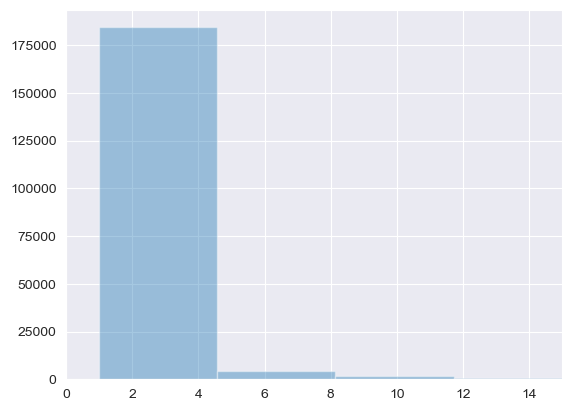

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 50, 
             kde= False);
plt.xlim([0.0,15])

C:\Users\inkyd\AppData\Local\Temp\ipykernel_9108\377184411.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist_train,


Text(0.5, 0, 'Mahalanobis dist')

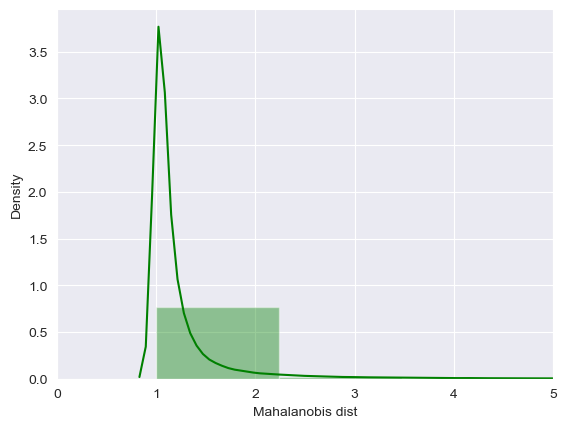

In [43]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [44]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob_dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob_dist'] > anomaly_train['Thresh']
anomaly_train.index = train_PCA.index

In [45]:
anomalies = anomaly_train[anomaly_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Mob_dist    Thresh  Anomaly
96951   5.322475  3.775882     True
96992   4.327879  3.775882     True
97006   7.068625  3.775882     True
97058   5.199892  3.775882     True
97077   6.080528  3.775882     True
...          ...       ...      ...
193748  4.667263  3.775882     True
193779  4.039112  3.775882     True
193801  4.337958  3.775882     True
193810  3.872145  3.775882     True
193828  8.451667  3.775882     True

[2643 rows x 3 columns]
(2643, 3)


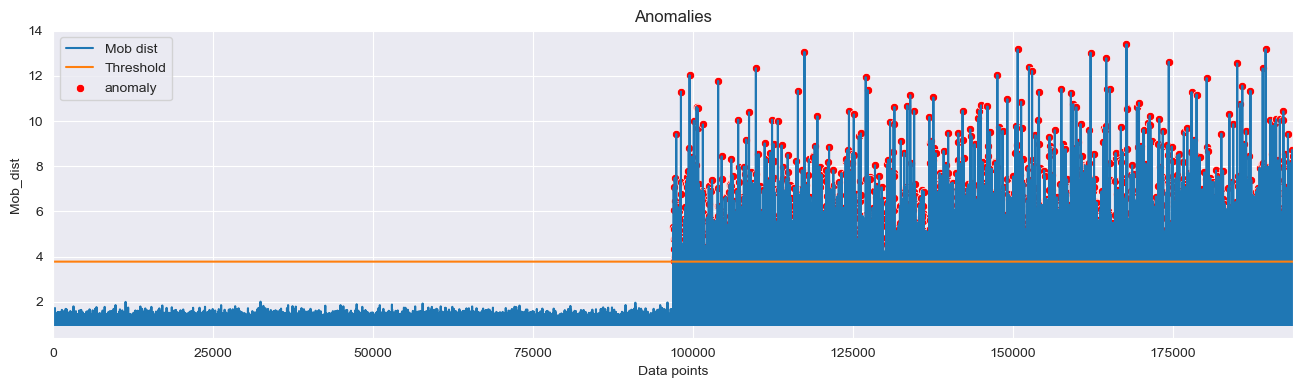

In [46]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(anomaly_train.index, anomaly_train.Mob_dist, label='Mob dist');
ax1.plot(anomaly_train.index, anomaly_train.Thresh, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [47]:
anomaly_test = pd.DataFrame()
anomaly_test['Mob_dist']= dist_test
anomaly_test['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_test['Anomaly'] = anomaly_test['Mob_dist'] > anomaly_test['Thresh']
anomaly_test.index = test_PCA.index
anomaly_test.head()

,Mob_dist,Thresh,Anomaly
0,1.012940,3.775882,False
1,1.014718,3.775882,False
2,1.137620,3.775882,False
3,1.011647,3.775882,False
4,1.000119,3.775882,False


In [48]:
OR_anomalies = anomaly_test[anomaly_test['Anomaly'] == True]
print(OR_anomalies)
print(OR_anomalies.shape)

       Mob_dist    Thresh  Anomaly
24241  4.074657  3.775882     True
24265  3.921837  3.775882     True
24306  4.970740  3.775882     True
24368  6.806733  3.775882     True
24386  6.085306  3.775882     True
...         ...       ...      ...
48416  3.836027  3.775882     True
48429  4.851952  3.775882     True
48450  7.043951  3.775882     True
48459  6.728307  3.775882     True
48461  4.936965  3.775882     True

[617 rows x 3 columns]
(617, 3)


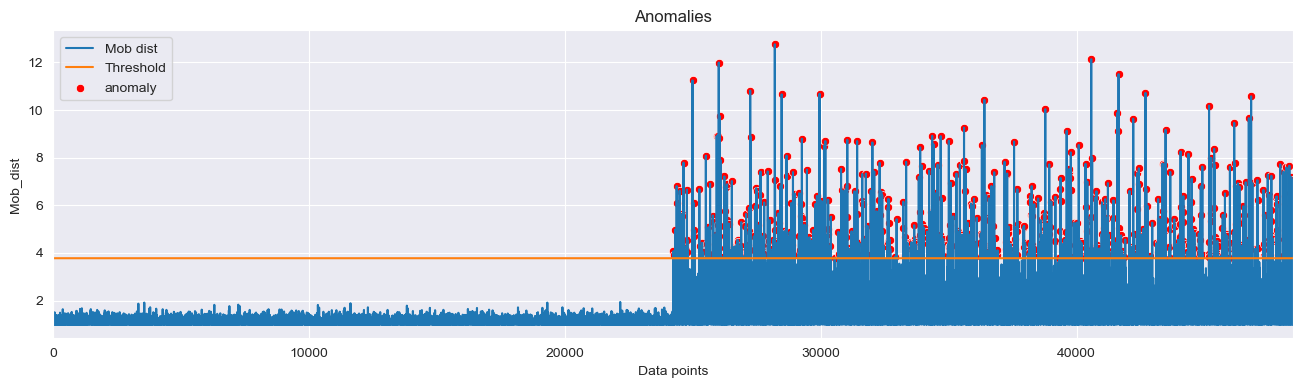

In [49]:
f, (ax2) = plt.subplots(figsize=(16, 4))
ax2.plot(anomaly_test.index, anomaly_test.Mob_dist, label='Mob dist');
ax2.plot(anomaly_test.index, anomaly_test.Thresh, label='Threshold')
g = sns.scatterplot(x=OR_anomalies.index , y=OR_anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_test.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [50]:
print("Anomalies: {}".format(OR_anomalies['Anomaly'].count()))

Anomalies: 617
